<a href="https://colab.research.google.com/github/sambitdash/EVA-2/blob/master/Session-6/Assignment-6A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment - 6B

## Importing Libraries and Symbols

In [31]:
from tensorflow.keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(2017) 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, concatenate, add
from tensorflow.keras import utils as np_utils

## Load the Dataset
CIFAR-10 dataset is loaded. It's  32×32  images with 50,000 images in the trainset and 10,000 in the test set.

In [32]:
from tensorflow.keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

## Show the Data
One sample data is shown from each class to get and understanding of the underlying data visually.

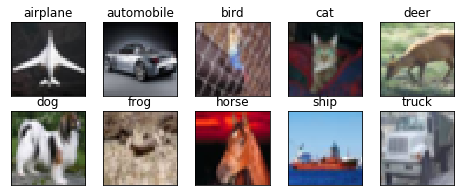

In [33]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Image Normalization

The images are normalized for the complete training set. Thus, the mean and standard deviation of the training set is assumed to be the true mean and standard deviations. 

In [34]:
#train_features /= 255
#train_features /= 255


X_mean = np.mean(train_features, axis=0, keepdims=True)
X_std  = np.std(train_features, axis=0, keepdims=True)
X_std  = np.clip(X_std, 1.0/255, 1.0)


train_features = train_features - X_mean
test_features  = test_features  - X_mean

train_features = np.divide(train_features, X_std)
test_features  = np.divide(test_features, X_std)

## Utility Methods

Two utility methods are generated:

1. Plot the model history of the loss and accuracy
2. Compute the final accuracy at the end of the runs

In [35]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['categorical_accuracy'])+1),model_history.history['categorical_accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_categorical_accuracy'])+1),model_history.history['val_categorical_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['categorical_accuracy'])+1),len(model_history.history['categorical_accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [36]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Convert output to one hot vector format

In [37]:
# train_features = train_features.astype('float32')/255
# test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_ohv = np_utils.to_categorical(train_labels, num_classes)
test_ohv  = np_utils.to_categorical(test_labels, num_classes)

print(test_ohv.shape)

(10000, 10)


## Model

The model has following characteristics.

1. Functional Model
2. Depth wise separated convolution, grouped convolutions all used once.
3. Padding used at several places to keep image size the same.

In [47]:
# Define the model

inputs = Input(shape=(32, 32, 3))
img = Conv2D(64, (3, 3), padding='same')(inputs)
img = DepthwiseConv2D((3, 1), padding='same')(img)
img = DepthwiseConv2D((1, 3), padding='same')(img)
img = BatchNormalization()(img)
img = Activation('relu')(img)

g1b1  = Conv2D(4,  (1, 1), padding='same', activation='relu')(img)
g1b1  = Conv2D(4,  (5, 5), padding='same', activation='relu')(g1b1)
g1b1  = Conv2D(64, (1, 1), padding='same', activation='relu')(g1b1)

g1b2  = Conv2D(4,  (1, 1), padding='same', activation='relu')(img)
g1b2  = Conv2D(4,  (3, 3), padding='same', activation='relu')(g1b2)
g1b2  = Conv2D(64, (1, 1), padding='same', activation='relu')(g1b2)

img = add([g1b1, g1b2])

g2b1  = Conv2D(4,  (1, 1), padding='same', activation='relu')(img)
g2b1  = Conv2D(4,  (3, 3), padding='same', activation='relu', dilation_rate=(1, 1))(g2b1)
g2b1  = Conv2D(64, (1, 1), padding='same', activation='relu')(g2b1)

g2b2  = Conv2D(4,  (1, 1), padding='same', activation='relu')(img)
g2b2  = Conv2D(4,  (3, 3), padding='same', activation='relu', dilation_rate=(2, 2))(g2b2)
g2b2  = Conv2D(64, (1, 1), padding='same', activation='relu')(g2b2)

img = add([g2b1, g2b2])

img = MaxPooling2D(pool_size=(2, 2))(img)
img = Conv2D(128, (3, 3), padding='same')(img)
img = DepthwiseConv2D((3, 3))(img)
img = BatchNormalization()(img)
img = Activation('relu')(img)

img = MaxPooling2D(pool_size=(2, 2))(img)
img = Conv2D(32, (3, 3), padding='same')(img)
img = Conv2D(32, (3, 3))(img)
img = BatchNormalization()(img)
img = Activation('relu')(img)
img = Conv2D(10, (3, 3))(img)
img = BatchNormalization()(img)
img = AveragePooling2D(pool_size=(2, 2))(img)
img = Activation('softmax')(img)
img = Flatten()(img)

model = Model(inputs=inputs, outputs=img)

from tensorflow.keras.optimizers import Adam
# Compile the model
model.compile(optimizer=Adam(lr=0.003), loss='poisson', metrics=['categorical_accuracy'])


In [48]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 32, 32, 64)   1792        input_13[0][0]                   
__________________________________________________________________________________________________
depthwise_conv2d_33 (DepthwiseC (None, 32, 32, 64)   256         conv2d_114[0][0]                 
__________________________________________________________________________________________________
depthwise_conv2d_34 (DepthwiseC (None, 32, 32, 64)   256         depthwise_conv2d_33[0][0]        
____________________________________________________________________________________________

## Training

Random eraser, image affine transformations are used as regularizers. Dropout was not used as random eraser has similar effect. 

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import LearningRateScheduler

(init_epoch, nepoch) = (0, 50)

def scheduler(epoch, lr):
  return 0.003 * 1/(1 + 0.3*(init_epoch+epoch))

import numpy as np

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser


datagen = ImageDataGenerator(
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True)
)


# train the model
start = time.time()

model_info = model.fit_generator(datagen.flow(train_features, train_ohv, batch_size = 128),
                                 epochs = nepoch, 
                                 validation_data = (test_features, test_ohv), verbose=1, 
                                 callbacks=[LearningRateScheduler(scheduler)])
end = time.time()

Epoch 1/50
391/391 [==============================] - 22s 56ms/step - loss: 0.2561 - categorical_accuracy: 0.4330 - val_loss: 0.2902 - val_categorical_accuracy: 0.3457
Epoch 2/50
391/391 [==============================] - 19s 48ms/step - loss: 0.2214 - categorical_accuracy: 0.5680 - val_loss: 0.2607 - val_categorical_accuracy: 0.4859
Epoch 3/50
391/391 [==============================] - 19s 48ms/step - loss: 0.2084 - categorical_accuracy: 0.6168 - val_loss: 0.2169 - val_categorical_accuracy: 0.6028
Epoch 4/50
391/391 [==============================] - 19s 48ms/step - loss: 0.2004 - categorical_accuracy: 0.6480 - val_loss: 0.2287 - val_categorical_accuracy: 0.5874
Epoch 5/50
391/391 [==============================] - 19s 48ms/step - loss: 0.1950 - categorical_accuracy: 0.6686 - val_loss: 0.2037 - val_categorical_accuracy: 0.6525
Epoch 6/50
391/391 [==============================] - 19s 48ms/step - loss: 0.1907 - categorical_accuracy: 0.6841 - val_loss: 0.2059 - val_categorical_accuracy:

391/391 [==============================] - 19s 48ms/step - loss: 0.1611 - categorical_accuracy: 0.7874 - val_loss: 0.1609 - val_categorical_accuracy: 0.7970
Epoch 50/50
391/391 [==============================] - 19s 48ms/step - loss: 0.1609 - categorical_accuracy: 0.7890 - val_loss: 0.1602 - val_categorical_accuracy: 0.7990


## Results

Model took 949.26 seconds to train


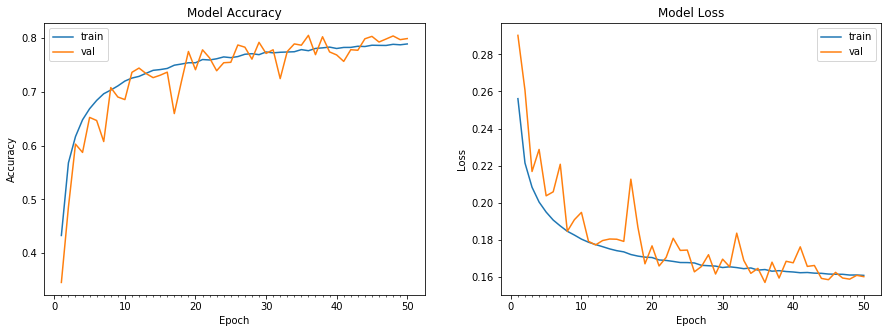

Accuracy on test data is: 79.90


In [50]:
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_ohv, model))